In [2]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 63 kB 522 kB/s eta 0:00:01
     |████████████████████████████████| 571 kB 2.6 MB/s eta 0:00:01
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
!pip install natsort

In [4]:
!pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12075 sha256=60724fef8c9725a5abbf853952a37ee9429cf3a14211867710328bef444d2596
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [5]:
# Configure the kaggle
!mkdir ~/.kaggle/
!echo '{"username":"liuzyon","key":"8d1e8007e8fc01e0c2e6498f3e5f3435"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download and unzip the dataset
!kaggle competitions download -c acse4-ml-2020
!unzip acse4-ml-2020.zip

In [7]:
import random
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset,random_split
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
import os
import collections
import seaborn as sns
from torch.utils.data import Dataset
import natsort
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [8]:
class CustomDataSet(Dataset):
    """
    Create the user dataset
    """
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            tensor_image = self.transform(image)
            return tensor_image
        else:
            return image

class DatasetFromSubset(Dataset):
    """
    Create the subset form another dataset
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [9]:
!ls ./xray-data/xray-data/

test  train


In [10]:
# Config the daatset path
data_dir = './xray-data/xray-data/'
train_data_dir = os.path.join(data_dir,'train')
test_data_dir = os.path.join(data_dir,'test')

In [11]:
# Load the dataset
image_dataset = datasets.ImageFolder(
    root=train_data_dir)
test_dataset = CustomDataSet(test_data_dir)

In [12]:
# The target class
img_labels = image_dataset.class_to_idx
img_labels

{'covid': 0, 'lung_opacity': 1, 'normal': 2, 'pneumonia': 3}

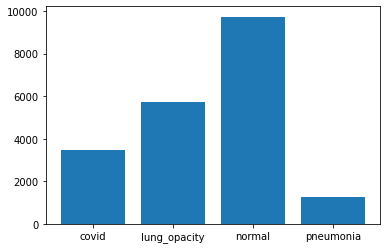

In [14]:
# Number of images for each classes
count_images = dict(collections.Counter(image_dataset.targets))
new_count_images = {}
for i, count in count_images.items():
    new_count_images[image_dataset.classes[i]] = count
    
plt.bar(range(len(new_count_images)), list(new_count_images.values()), align='center')
plt.xticks(range(len(new_count_images)), list(new_count_images.keys()))
plt.show()

In [15]:
# Data transform for orginal dataset
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),])

# Data transform for data augmentation
aug_transform = transforms.Compose(
               [transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomCrop(size=[299,299], padding=[0, 4]),
                transforms.RandomRotation([0, 20]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),])

# Original training dataset
image_dataset_unaug = datasets.ImageFolder(
    root=train_data_dir, transform=data_transform)
# Training dataset after transformed
image_dataset_aug = datasets.ImageFolder(
    root=train_data_dir, transform=aug_transform)

# Combine the above dataset
image_dataset = torch.utils.data.ConcatDataset([image_dataset_unaug,image_dataset_aug])
targets = image_dataset_unaug.targets + image_dataset_aug.targets

In [16]:
# Then length of training dataset
len(image_dataset)

40430

In [17]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 299, 299))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 299, 299))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [18]:
# Define the hyperparameters
seed = 42
lr = 1e-3
momentum = 0.9
batch_size = 64
test_batch_size = 64
n_epochs = 30

In [20]:
def set_parameter_requires_grad(model, freeze_layers, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    ct = 0
    for child in model.children():
        ct += 1
        if ct < freeze_layers:
            for param in child.parameters():
                param.requires_grad = False
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

In [21]:
set_seed(seed)

import torch
# variants of resnets
# model = models.resnet18(pretrained=True).to(device)
# model = models.resnet34(pretrained=True).to(device)
model = models.resnet50(pretrained=True).to(device)
# model = models.resnet101(pretrained=True).to(device)
# model = models.resnet152(pretrained=True).to(device)

# Freeze the part layer of parameters
set_parameter_requires_grad(model, freeze_layers=9, requires_grad=False)

# Set the full connected layer
model.fc = nn.Linear(model.fc.in_features, 4).to(device)  # newly initialised layers automatically have requires_grad=True （新初始化的层自动有requires_grad=True）

print(len(get_params_to_update(model)))
# print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2


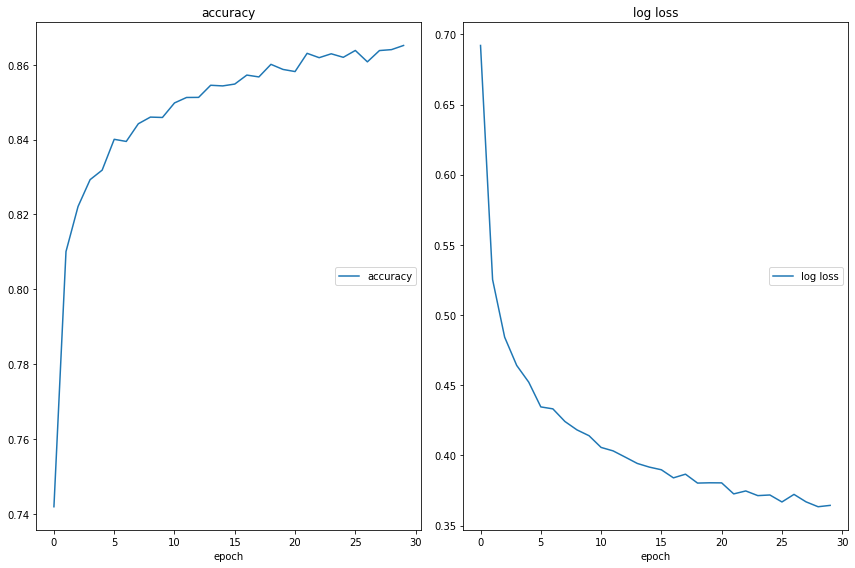

accuracy
	accuracy         	 (min:    0.742, max:    0.865, cur:    0.865)
log loss
	log loss         	 (min:    0.363, max:    0.692, cur:    0.364)


In [22]:
# Train the network

# Define the optimizer
optimizer = torch.optim.SGD(get_params_to_update(model), lr=lr, momentum=momentum)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the full training dataset loader
train_loader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    # Plot the accuracy and loss
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

# Save the model
model_save_name = 'ResNet50_Xray_classifier_partfreeze_data_aug_SGD_e-3_full.pt'
path = F"./{model_save_name}" 
torch.save(model.state_dict(), path)


In [ ]:
# Do the test and save as .csv
import pandas as pd
from PIL import Image

# Load the saved model trained
PATH = './ResNet50_Xray_classifier_partfreeze_data_aug_SGD_e-3_full.pt'
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 4).to(device) 
model.load_state_dict(torch.load(PATH))
model.eval()

# Transform the test dataset
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Predict the test dataset
test_file_list = []
classification_list = []

for test_file in os.listdir(test_data_dir):

    test_file_list.append(test_file.split(".")[0])

    input_image = Image.open(os.path.join(test_data_dir,test_file))
    input_image = input_image.convert('RGB')
    input_tensor = preprocess(input_image)

    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    #print("The category for file {} is {}".format(test_file, probabilities.argmax()))
    classification_list.append(probabilities.argmax().item())

# Save the prediction
test_df = pd.DataFrame({'name':test_file_list, 'target':classification_list})
test_df['num'] = test_df['name'].apply(lambda x:int(x[5:]))
test_df.sort_values('num', inplace=True)
test_df = test_df[['name', 'target']]
test_df.to_csv('ResNet50_Xray_classifier_partfreeze_data_aug_SGD_e-3_full.csv', sep=',', index=False)